In [1]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import pickle
import librosa
import random
import glob
import soundfile as sf
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

## Speech Denoising Using RNN

### Loading and Processing Data

In [3]:
path = 'timit-homework'
train_path = path +'/tr/'
test_path = path + '/te/'
val_path = path+'/v/'
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)
val_files = os.listdir(val_path)
trx = sorted([file for file in train_files if file.startswith('trx')])
trs = sorted([file for file in train_files if file.startswith('trs')])
trn = sorted([file for file in train_files if file.startswith('trn')])
vx = sorted([file for file in val_files if file.startswith('vx')])
vs = sorted([file for file in val_files if file.startswith('vs')])
vn = sorted([file for file in val_files if file.startswith('vn')])
tex = sorted([file for file in test_files if file.startswith('tex')])

In [4]:
def load_files(path, files):  
    spectogram = []
    spectogram_mag = []
    for file in tqdm(files):
        s, sr = librosa.load(path+file, sr=None)
        S=librosa.stft(s, n_fft=1024, hop_length=512)
        spectogram.append(S)
        s_abs = np.abs(S)
        spectogram_mag.append(s_abs)
        del s,S,s_abs
    return spectogram, spectogram_mag

In [5]:
X_val_spect, X_val = load_files(val_path, vx)
S_val_spect, S_val = load_files(val_path, vs)
N_val_spect, N_val = load_files(val_path, vn)

100%|█████████████████████████████████████████| 1200/1200 [00:18<00:00, 63.84it/s]


In [7]:
X_tr_spect, X_tr = load_files(train_path, trx)
S_tr_spect, S_tr = load_files(train_path, trs)
N_tr_spect, N_tr = load_files(train_path, trn)

100%|████████████████████████████████████████| 1200/1200 [00:03<00:00, 303.42it/s]


In [8]:
def pad(matrix):
    for i in range(len(matrix)):
        pad = 10 - (matrix[i].shape[1] % 10)
        small_value = np.random.normal(0,0.00001, size = [matrix[i].shape[0],int(pad)])
        matrix[i] = np.concatenate((matrix[i],small_value), axis = 1)

In [9]:
pad(X_tr)
pad(S_tr)
pad(N_tr)
pad(X_val)
pad(S_val)
pad(N_val)

In [17]:
# def IBM(clean_mag, noise_mag):
#     """Create IBM following equation (10)"""
#     return (signal > noise)*1
def IBM(clean_mag, noise_mag):
    """
    M_f,t^(l) = 1 if |S_tr^(l)|_f,t > |N_tr^(l)|_f,t
                0 if |S_tr^(l)|_f,t ≤ |N_tr^(l)|_f,t
    """
    clean_mag = np.abs(clean_mag)
    noise_mag = np.abs(noise_mag)
    
    min_len = min(clean_mag.shape[1], noise_mag.shape[1])
    
    clean_truncated = clean_mag[:, :min_len]
    noise_truncated = noise_mag[:, :min_len]
    mask = (clean_truncated > noise_truncated).astype(np.float32)
    
    return mask

In [18]:
Mask=[]
for signal, noise in zip(S_tr,N_tr):
    Mask.append(IBM(signal, noise))

Mask_val=[]
for signal, noise in zip(S_val,N_val):
    Mask_val.append(IBM(signal, noise))

In [19]:
def batches(X):
    batch = []
    for arr in X:
        arr2 = []
        for col in range(arr.shape[1]//10):
            temp_arr = arr[:,10*col:10*col+10]
            arr2.append(temp_arr)
        arr2 = np.array(arr2)
        batch.append(arr2)
    return np.concatenate(batch)

X_tr_batch = batches(X_tr)
X_val_batch = batches(X_val)

Mask_batch = batches(Mask)
Mask_batch_val = batches(Mask_val)

### RNN Network

In [20]:
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Dropout, Bidirectional

rnn_model = models.Sequential([
            InputLayer(shape = (None, 513)),
            Masking(mask_value=0.0),
            GRU(513, return_sequences = True),
            Dropout(0.1),
            GRU(513, return_sequences = True),
            Dropout(0.1),
#             GRU(513, return_sequences = True),
#             Dropout(0.1),
            Dense(513, activation='sigmoid'),
])

In [21]:
rnn_model.compile(loss='binary_crossentropy',optimizer='adam')
print(rnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, None, 513)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, None, 513)      │     1,582,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 513)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, None, 513)      │     1,582,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 513)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 513)      │       263,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,427,866 (13.08 MB)

 Trainable params: 3,427,866 (13.08 MB)

 Non-trainable params: 0 (0.00 B)

None


### Validation Loss and SNR

In [22]:
# history = model.fit(np.transpose(X_tr_batch,(0,2,1)), np.transpose(Mask_batch,(0,2,1)),
#                     validation_data=(np.transpose(X_val_batch,(0,2,1)), np.transpose(Mask_batch_val,(0,2,1))), 
#                     epochs = 50, batch_size = 32)

with tf.device('/CPU:0'):
    rnn_history = rnn_model.fit(np.transpose(X_tr_batch,(0,2,1)), 
                                np.transpose(Mask_batch,(0,2,1)),
                                validation_data=(np.transpose(X_val_batch,(0,2,1)), 
                                np.transpose(Mask_batch_val,(0,2,1))), 
                                epochs = 50, 
                                batch_size = 512)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - loss: 0.6669 - val_loss: 0.6099
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - loss: 0.5975 - val_loss: 0.5638
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - loss: 0.5693 - val_loss: 0.5380
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - loss: 0.5484 - val_loss: 0.5181
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - loss: 0.5268 - val_loss: 0.5040
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - loss: 0.5160 - val_loss: 0.4952
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - loss: 0.5009 - val_loss: 0.4835
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - loss: 0.4904 - val_loss: 0.4766
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - loss: 0.4873 - val_loss: 0.4726
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - loss: 0.4811 - val_loss: 0.4638
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step - loss: 0.4725 - val_loss: 0.4609
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/ste

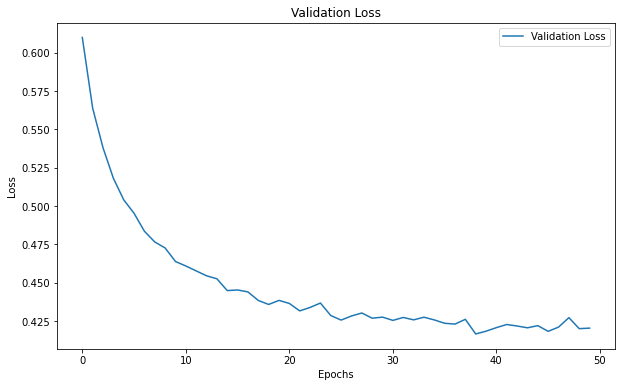

In [25]:
plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [27]:
S_val_pred = []
for i in tqdm(range(len(X_val_spect))):
    x_val_spect = X_val_spect[i]
    x_val_abs = X_val[i]
    
    # length of this spectrogram
    spec_length = x_val_spect.shape[1]
    
    # predict mask and reshape to match spectrogram shape
    m_pred = np.round(rnn_model.predict(x_val_abs.T.reshape([1,-1,513])).squeeze())
    m_pred = m_pred[:spec_length]  # truncate to match spectrogram length
    
    # apply mask
    s_pred = (m_pred.T)*x_val_spect
    S_val_pred.append(s_pred)


  0%|                                                    | 0/1200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



  0%|                                            | 1/1200 [00:01<23:06,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  0%|                                            | 3/1200 [00:01<07:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



  0%|▏                                           | 5/1200 [00:01<04:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  1%|▎                                           | 7/1200 [00:01<03:10,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



  1%|▎                                           | 9/1200 [00:01<02:34,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step



  1%|▍                                          | 11/1200 [00:02<02:37,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  1%|▍                                          | 13/1200 [00:02<02:34,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  1%|▌                                          | 15/1200 [00:02<02:18,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  1%|▌                                          | 17/1200 [00:02<02:08,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  2%|▋                                          | 19/1200 [00:02<02:01,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  2%|▊                                          | 21/1200 [00:03<01:57, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  2%|▊                                          | 23/1200 [00:03<01:50, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  2%|▉                                          | 25/1200 [00:03<01:44, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  2%|▉                                          | 27/1200 [00:03<01:41, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  2%|█                                          | 29/1200 [00:03<01:37, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



  3%|█                                          | 31/1200 [00:03<01:36, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  3%|█▏                                         | 33/1200 [00:04<01:37, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  3%|█▎                                         | 35/1200 [00:04<01:37, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  3%|█▎                                         | 37/1200 [00:04<01:35, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



  3%|█▍                                         | 39/1200 [00:04<01:37, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  3%|█▍                                         | 41/1200 [00:04<01:41, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  4%|█▌                                         | 43/1200 [00:04<01:42, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  4%|█▌                                         | 45/1200 [00:05<01:42, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  4%|█▋                                         | 47/1200 [00:05<01:39, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  4%|█▊                                         | 49/1200 [00:05<01:36, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  4%|█▊                                         | 51/1200 [00:05<01:38, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  4%|█▉                                         | 53/1200 [00:05<01:37, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  5%|█▉                                         | 55/1200 [00:05<01:38, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  5%|██                                         | 57/1200 [00:06<01:39, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  5%|██                                         | 59/1200 [00:06<01:37, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  5%|██▏                                        | 61/1200 [00:06<01:38, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  5%|██▎                                        | 63/1200 [00:06<01:38, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  5%|██▎                                        | 65/1200 [00:06<01:35, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  6%|██▍                                        | 67/1200 [00:06<01:37, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  6%|██▍                                        | 69/1200 [00:07<01:35, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  6%|██▌                                        | 71/1200 [00:07<01:35, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  6%|██▌                                        | 73/1200 [00:07<01:36, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  6%|██▋                                        | 75/1200 [00:07<01:36, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  6%|██▊                                        | 77/1200 [00:07<01:37, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  7%|██▊                                        | 79/1200 [00:07<01:36, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  7%|██▉                                        | 81/1200 [00:08<01:35, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  7%|██▉                                        | 83/1200 [00:08<01:32, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  7%|███                                        | 85/1200 [00:08<01:31, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  7%|███                                        | 87/1200 [00:08<01:30, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  7%|███▏                                       | 89/1200 [00:08<01:30, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  8%|███▎                                       | 91/1200 [00:08<01:32, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  8%|███▎                                       | 93/1200 [00:09<01:32, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  8%|███▍                                       | 95/1200 [00:09<01:33, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  8%|███▍                                       | 97/1200 [00:09<01:32, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  8%|███▌                                       | 99/1200 [00:09<01:32, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  8%|███▌                                      | 101/1200 [00:09<01:31, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  9%|███▌                                      | 103/1200 [00:09<01:31, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  9%|███▋                                      | 105/1200 [00:10<01:31, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  9%|███▋                                      | 107/1200 [00:10<01:30, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  9%|███▊                                      | 109/1200 [00:10<01:33, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



  9%|███▉                                      | 111/1200 [00:10<01:33, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



  9%|███▉                                      | 113/1200 [00:10<01:30, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 10%|████                                      | 115/1200 [00:10<01:31, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 10%|████                                      | 117/1200 [00:11<01:29, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 10%|████▏                                     | 119/1200 [00:11<01:28, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 10%|████▏                                     | 121/1200 [00:11<01:29, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 10%|████▎                                     | 123/1200 [00:11<01:27, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 10%|████▍                                     | 125/1200 [00:11<01:28, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 11%|████▍                                     | 127/1200 [00:11<01:27, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 11%|████▌                                     | 129/1200 [00:12<01:28, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 11%|████▌                                     | 131/1200 [00:12<01:29, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 11%|████▋                                     | 133/1200 [00:12<01:31, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 11%|████▋                                     | 135/1200 [00:12<01:29, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 11%|████▊                                     | 137/1200 [00:12<01:28, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 12%|████▊                                     | 139/1200 [00:12<01:31, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 12%|████▉                                     | 141/1200 [00:13<01:32, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 12%|█████                                     | 143/1200 [00:13<01:32, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



 12%|█████                                     | 145/1200 [00:13<01:31, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 12%|█████▏                                    | 147/1200 [00:13<01:33, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 12%|█████▏                                    | 149/1200 [00:13<01:31, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 13%|█████▎                                    | 151/1200 [00:14<01:31, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 13%|█████▎                                    | 153/1200 [00:14<01:28, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 13%|█████▍                                    | 155/1200 [00:14<01:27, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 13%|█████▍                                    | 157/1200 [00:14<01:28, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 13%|█████▌                                    | 159/1200 [00:14<01:26, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 13%|█████▋                                    | 161/1200 [00:14<01:27, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 14%|█████▋                                    | 163/1200 [00:15<01:31, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 14%|█████▊                                    | 165/1200 [00:15<01:30, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 14%|█████▊                                    | 167/1200 [00:15<01:28, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 14%|█████▉                                    | 169/1200 [00:15<01:28, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 14%|█████▉                                    | 171/1200 [00:15<01:28, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 14%|██████                                    | 173/1200 [00:15<01:26, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 15%|██████▏                                   | 175/1200 [00:16<01:26, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 15%|██████▏                                   | 177/1200 [00:16<01:25, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 15%|██████▎                                   | 179/1200 [00:16<01:25, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 15%|██████▎                                   | 181/1200 [00:16<01:26, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 15%|██████▍                                   | 183/1200 [00:16<01:25, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 15%|██████▍                                   | 185/1200 [00:16<01:25, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|██████▌                                   | 187/1200 [00:17<01:26, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|██████▌                                   | 189/1200 [00:17<01:25, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|██████▋                                   | 191/1200 [00:17<01:26, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 16%|██████▊                                   | 193/1200 [00:17<01:29, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 16%|██████▊                                   | 195/1200 [00:17<01:27, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 16%|██████▉                                   | 197/1200 [00:17<01:26, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 17%|██████▉                                   | 199/1200 [00:18<01:25, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 17%|███████                                   | 201/1200 [00:18<01:24, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 17%|███████                                   | 203/1200 [00:18<01:23, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 17%|███████▏                                  | 205/1200 [00:18<01:25, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 17%|███████▏                                  | 207/1200 [00:18<01:27, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 17%|███████▎                                  | 209/1200 [00:18<01:25, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 18%|███████▍                                  | 211/1200 [00:19<01:24, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 18%|███████▍                                  | 213/1200 [00:19<01:25, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 18%|███████▌                                  | 215/1200 [00:19<01:26, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 18%|███████▌                                  | 217/1200 [00:19<01:25, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 18%|███████▋                                  | 219/1200 [00:19<01:25, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 18%|███████▋                                  | 221/1200 [00:20<01:24, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 19%|███████▊                                  | 223/1200 [00:20<01:23, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 19%|███████▉                                  | 225/1200 [00:20<01:22, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 19%|███████▉                                  | 227/1200 [00:20<01:20, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 19%|████████                                  | 229/1200 [00:20<01:20, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 19%|████████                                  | 231/1200 [00:20<01:19, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 19%|████████▏                                 | 233/1200 [00:21<01:19, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 20%|████████▏                                 | 235/1200 [00:21<01:20, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 20%|████████▎                                 | 237/1200 [00:21<01:20, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 20%|████████▎                                 | 239/1200 [00:21<01:23, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 20%|████████▍                                 | 241/1200 [00:21<01:22, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 20%|████████▌                                 | 243/1200 [00:21<01:23, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 20%|████████▌                                 | 245/1200 [00:22<01:24, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 21%|████████▋                                 | 247/1200 [00:22<01:24, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 21%|████████▋                                 | 249/1200 [00:22<01:24, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 21%|████████▊                                 | 251/1200 [00:22<01:24, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 21%|████████▊                                 | 253/1200 [00:22<01:22, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 21%|████████▉                                 | 255/1200 [00:22<01:20, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 21%|████████▉                                 | 257/1200 [00:23<01:20, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 22%|█████████                                 | 259/1200 [00:23<01:24, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 22%|█████████▏                                | 261/1200 [00:23<01:23, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 22%|█████████▏                                | 263/1200 [00:23<01:23, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 22%|█████████▎                                | 265/1200 [00:23<01:21, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 22%|█████████▎                                | 267/1200 [00:23<01:19, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 22%|█████████▍                                | 269/1200 [00:24<01:20, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 23%|█████████▍                                | 271/1200 [00:24<01:21, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 23%|█████████▌                                | 273/1200 [00:24<01:21, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 23%|█████████▋                                | 275/1200 [00:24<01:22, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 23%|█████████▋                                | 277/1200 [00:24<01:23, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 23%|█████████▊                                | 279/1200 [00:25<01:21, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 23%|█████████▊                                | 281/1200 [00:25<01:20, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 24%|█████████▉                                | 283/1200 [00:25<01:19, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 24%|█████████▉                                | 285/1200 [00:25<01:17, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 24%|██████████                                | 287/1200 [00:25<01:17, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 24%|██████████                                | 289/1200 [00:25<01:18, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 24%|██████████▏                               | 291/1200 [00:26<01:17, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 24%|██████████▎                               | 293/1200 [00:26<01:17, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 25%|██████████▎                               | 295/1200 [00:26<01:16, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 25%|██████████▍                               | 297/1200 [00:26<01:16, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 25%|██████████▍                               | 299/1200 [00:26<01:16, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 25%|██████████▌                               | 301/1200 [00:26<01:15, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 25%|██████████▌                               | 303/1200 [00:27<01:14, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 25%|██████████▋                               | 305/1200 [00:27<01:14, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 26%|██████████▋                               | 307/1200 [00:27<01:13, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 26%|██████████▊                               | 309/1200 [00:27<01:12, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 26%|██████████▉                               | 311/1200 [00:27<01:11, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 26%|██████████▉                               | 313/1200 [00:27<01:11, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 26%|███████████                               | 315/1200 [00:28<01:11, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 26%|███████████                               | 317/1200 [00:28<01:12, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 27%|███████████▏                              | 319/1200 [00:28<01:12, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 27%|███████████▏                              | 321/1200 [00:28<01:12, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 27%|███████████▎                              | 323/1200 [00:28<01:11, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 27%|███████████▍                              | 325/1200 [00:28<01:11, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 27%|███████████▍                              | 327/1200 [00:29<01:11, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 27%|███████████▌                              | 329/1200 [00:29<01:10, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 28%|███████████▌                              | 331/1200 [00:29<01:14, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 28%|███████████▋                              | 333/1200 [00:29<01:13, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 28%|███████████▋                              | 335/1200 [00:29<01:13, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 28%|███████████▊                              | 337/1200 [00:29<01:12, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 28%|███████████▊                              | 339/1200 [00:30<01:13, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 28%|███████████▉                              | 341/1200 [00:30<01:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 29%|████████████                              | 343/1200 [00:30<01:15, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 29%|████████████                              | 345/1200 [00:30<01:15, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 29%|████████████▏                             | 347/1200 [00:30<01:13, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 29%|████████████▏                             | 349/1200 [00:30<01:13, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 29%|████████████▎                             | 351/1200 [00:31<01:12, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 29%|████████████▎                             | 353/1200 [00:31<01:11, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 30%|████████████▍                             | 355/1200 [00:31<01:10, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 30%|████████████▍                             | 357/1200 [00:31<01:09, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 30%|████████████▌                             | 359/1200 [00:31<01:10, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 30%|████████████▋                             | 361/1200 [00:31<01:09, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 30%|████████████▋                             | 363/1200 [00:32<01:10, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 30%|████████████▊                             | 365/1200 [00:32<01:09, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 31%|████████████▊                             | 367/1200 [00:32<01:10, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 31%|████████████▉                             | 369/1200 [00:32<01:09, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 31%|████████████▉                             | 371/1200 [00:32<01:11, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 31%|█████████████                             | 373/1200 [00:32<01:10, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 31%|█████████████▏                            | 375/1200 [00:33<01:09, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 31%|█████████████▏                            | 377/1200 [00:33<01:09, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 32%|█████████████▎                            | 379/1200 [00:33<01:09, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 32%|█████████████▎                            | 381/1200 [00:33<01:08, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 32%|█████████████▍                            | 383/1200 [00:33<01:07, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 32%|█████████████▍                            | 385/1200 [00:33<01:09, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 32%|█████████████▌                            | 387/1200 [00:34<01:08, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 32%|█████████████▌                            | 389/1200 [00:34<01:08, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|█████████████▋                            | 391/1200 [00:34<01:07, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|█████████████▊                            | 393/1200 [00:34<01:08, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|█████████████▊                            | 395/1200 [00:34<01:09, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|█████████████▉                            | 397/1200 [00:34<01:07, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|█████████████▉                            | 399/1200 [00:35<01:08, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|██████████████                            | 401/1200 [00:35<01:10, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 34%|██████████████                            | 403/1200 [00:35<01:08, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 34%|██████████████▏                           | 405/1200 [00:35<01:09, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 34%|██████████████▏                           | 407/1200 [00:35<01:11, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 34%|██████████████▎                           | 409/1200 [00:36<01:09, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 34%|██████████████▍                           | 411/1200 [00:36<01:09, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 34%|██████████████▍                           | 413/1200 [00:36<01:07, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 35%|██████████████▌                           | 415/1200 [00:36<01:09, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 35%|██████████████▌                           | 417/1200 [00:36<01:10, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 35%|██████████████▋                           | 419/1200 [00:36<01:09, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 35%|██████████████▋                           | 421/1200 [00:37<01:07, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 35%|██████████████▊                           | 423/1200 [00:37<01:07, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 35%|██████████████▉                           | 425/1200 [00:37<01:05, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 36%|██████████████▉                           | 427/1200 [00:37<01:04, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 36%|███████████████                           | 429/1200 [00:37<01:04, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 36%|███████████████                           | 431/1200 [00:37<01:03, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 36%|███████████████▏                          | 433/1200 [00:38<01:02, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 36%|███████████████▏                          | 435/1200 [00:38<01:04, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 36%|███████████████▎                          | 437/1200 [00:38<01:04, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 37%|███████████████▎                          | 439/1200 [00:38<01:06, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 37%|███████████████▍                          | 441/1200 [00:38<01:05, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 37%|███████████████▌                          | 443/1200 [00:38<01:04, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 37%|███████████████▌                          | 445/1200 [00:39<01:05, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 37%|███████████████▋                          | 447/1200 [00:39<01:06, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 37%|███████████████▋                          | 449/1200 [00:39<01:04, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 38%|███████████████▊                          | 451/1200 [00:39<01:05, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 38%|███████████████▊                          | 453/1200 [00:39<01:06, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 38%|███████████████▉                          | 455/1200 [00:39<01:05, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 38%|███████████████▉                          | 457/1200 [00:40<01:06, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 38%|████████████████                          | 459/1200 [00:40<01:05, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 38%|████████████████▏                         | 461/1200 [00:40<01:05, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 39%|████████████████▏                         | 463/1200 [00:40<01:04, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 39%|████████████████▎                         | 465/1200 [00:40<01:03, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 39%|████████████████▎                         | 467/1200 [00:41<01:02, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 39%|████████████████▍                         | 469/1200 [00:41<01:00, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 39%|████████████████▍                         | 471/1200 [00:41<01:00, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 39%|████████████████▌                         | 473/1200 [00:41<00:59, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 40%|████████████████▋                         | 475/1200 [00:41<01:02, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 40%|████████████████▋                         | 477/1200 [00:41<01:01, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 40%|████████████████▊                         | 479/1200 [00:42<01:01, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 40%|████████████████▊                         | 481/1200 [00:42<01:00, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 40%|████████████████▉                         | 483/1200 [00:42<00:59, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 40%|████████████████▉                         | 485/1200 [00:42<01:00, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 41%|█████████████████                         | 487/1200 [00:42<01:00, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 41%|█████████████████                         | 489/1200 [00:42<01:02, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 41%|█████████████████▏                        | 491/1200 [00:43<01:04, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 41%|█████████████████▎                        | 493/1200 [00:43<01:02, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 41%|█████████████████▎                        | 495/1200 [00:43<01:03, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 41%|█████████████████▍                        | 497/1200 [00:43<01:01, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 42%|█████████████████▍                        | 499/1200 [00:43<01:00, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 42%|█████████████████▌                        | 501/1200 [00:43<01:00, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 42%|█████████████████▌                        | 503/1200 [00:44<00:59, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 42%|█████████████████▋                        | 505/1200 [00:44<00:59, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 42%|█████████████████▋                        | 507/1200 [00:44<00:59, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 42%|█████████████████▊                        | 509/1200 [00:44<01:00, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 43%|█████████████████▉                        | 511/1200 [00:44<00:59, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 43%|█████████████████▉                        | 513/1200 [00:44<01:00, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 43%|██████████████████                        | 515/1200 [00:45<00:58, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 43%|██████████████████                        | 517/1200 [00:45<00:57, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 43%|██████████████████▏                       | 519/1200 [00:45<00:56, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 43%|██████████████████▏                       | 521/1200 [00:45<00:55, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 44%|██████████████████▎                       | 523/1200 [00:45<00:55, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 44%|██████████████████▍                       | 525/1200 [00:45<00:56, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 44%|██████████████████▍                       | 527/1200 [00:46<00:59, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 44%|██████████████████▌                       | 529/1200 [00:46<00:59, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 44%|██████████████████▌                       | 531/1200 [00:46<00:59, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 44%|██████████████████▋                       | 533/1200 [00:46<00:58, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 45%|██████████████████▋                       | 535/1200 [00:46<00:57, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 45%|██████████████████▊                       | 537/1200 [00:47<00:56, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 45%|██████████████████▊                       | 539/1200 [00:47<00:57, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 45%|██████████████████▉                       | 541/1200 [00:47<00:57, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 45%|███████████████████                       | 543/1200 [00:47<00:57, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 45%|███████████████████                       | 545/1200 [00:47<00:56, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 46%|███████████████████▏                      | 547/1200 [00:47<00:57, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 46%|███████████████████▏                      | 549/1200 [00:48<00:56, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 46%|███████████████████▎                      | 551/1200 [00:48<00:55, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 46%|███████████████████▎                      | 553/1200 [00:48<00:57, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 46%|███████████████████▍                      | 555/1200 [00:48<00:56, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 46%|███████████████████▍                      | 557/1200 [00:48<00:54, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 47%|███████████████████▌                      | 559/1200 [00:48<00:53, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 47%|███████████████████▋                      | 561/1200 [00:49<00:53, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 47%|███████████████████▋                      | 563/1200 [00:49<00:52, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 47%|███████████████████▊                      | 565/1200 [00:49<00:51, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 47%|███████████████████▊                      | 567/1200 [00:49<00:50, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 47%|███████████████████▉                      | 569/1200 [00:49<00:49, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 48%|███████████████████▉                      | 571/1200 [00:49<00:50, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 48%|████████████████████                      | 573/1200 [00:50<00:50, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 48%|████████████████████▏                     | 575/1200 [00:50<00:50, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 48%|████████████████████▏                     | 577/1200 [00:50<00:52, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 48%|████████████████████▎                     | 579/1200 [00:50<00:52, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 48%|████████████████████▎                     | 581/1200 [00:50<00:52, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 49%|████████████████████▍                     | 583/1200 [00:50<00:52, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 49%|████████████████████▍                     | 585/1200 [00:51<00:54, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 49%|████████████████████▌                     | 587/1200 [00:51<00:52, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 49%|████████████████████▌                     | 589/1200 [00:51<00:52, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 49%|████████████████████▋                     | 591/1200 [00:51<00:53, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 49%|████████████████████▊                     | 593/1200 [00:51<00:52, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 50%|████████████████████▊                     | 595/1200 [00:51<00:50, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 50%|████████████████████▉                     | 597/1200 [00:52<00:51, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 50%|████████████████████▉                     | 599/1200 [00:52<00:51, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 50%|█████████████████████                     | 601/1200 [00:52<00:51, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 50%|█████████████████████                     | 603/1200 [00:52<00:50, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 50%|█████████████████████▏                    | 605/1200 [00:52<00:49, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 51%|█████████████████████▏                    | 607/1200 [00:53<00:53, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 51%|█████████████████████▎                    | 609/1200 [00:53<00:55, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 51%|█████████████████████▍                    | 611/1200 [00:53<00:54, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 51%|█████████████████████▍                    | 613/1200 [00:53<00:53, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 51%|█████████████████████▌                    | 615/1200 [00:53<00:51, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 51%|█████████████████████▌                    | 617/1200 [00:53<00:49, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|█████████████████████▋                    | 619/1200 [00:54<00:50, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 52%|█████████████████████▋                    | 621/1200 [00:54<00:49, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|█████████████████████▊                    | 623/1200 [00:54<00:48, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|█████████████████████▉                    | 625/1200 [00:54<00:48, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|█████████████████████▉                    | 627/1200 [00:54<00:47, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 52%|██████████████████████                    | 629/1200 [00:54<00:47, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 53%|██████████████████████                    | 631/1200 [00:55<00:46, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 53%|██████████████████████▏                   | 633/1200 [00:55<00:47, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 53%|██████████████████████▏                   | 635/1200 [00:55<00:47, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 53%|██████████████████████▎                   | 637/1200 [00:55<00:45, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 53%|██████████████████████▎                   | 639/1200 [00:55<00:46, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 53%|██████████████████████▍                   | 641/1200 [00:55<00:46, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 54%|██████████████████████▌                   | 643/1200 [00:56<00:47, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 54%|██████████████████████▌                   | 645/1200 [00:56<00:46, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 54%|██████████████████████▋                   | 647/1200 [00:56<00:45, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 54%|██████████████████████▋                   | 649/1200 [00:56<00:45, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 54%|██████████████████████▊                   | 651/1200 [00:56<00:45, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 54%|██████████████████████▊                   | 653/1200 [00:56<00:44, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 55%|██████████████████████▉                   | 655/1200 [00:57<00:45, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 55%|██████████████████████▉                   | 657/1200 [00:57<00:45, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 55%|███████████████████████                   | 659/1200 [00:57<00:45, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 55%|███████████████████████▏                  | 661/1200 [00:57<00:45, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 55%|███████████████████████▏                  | 663/1200 [00:57<00:45, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 55%|███████████████████████▎                  | 665/1200 [00:57<00:45, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 56%|███████████████████████▎                  | 667/1200 [00:58<00:45, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 56%|███████████████████████▍                  | 669/1200 [00:58<00:44, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 56%|███████████████████████▍                  | 671/1200 [00:58<00:45, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 56%|███████████████████████▌                  | 673/1200 [00:58<00:45, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 56%|███████████████████████▋                  | 675/1200 [00:58<00:46, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 56%|███████████████████████▋                  | 677/1200 [00:58<00:47, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 57%|███████████████████████▊                  | 679/1200 [00:59<00:46, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 57%|███████████████████████▊                  | 681/1200 [00:59<00:45, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 57%|███████████████████████▉                  | 683/1200 [00:59<00:45, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 57%|███████████████████████▉                  | 685/1200 [00:59<00:45, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 57%|████████████████████████                  | 687/1200 [00:59<00:44, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 57%|████████████████████████                  | 689/1200 [01:00<00:43, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 58%|████████████████████████▏                 | 691/1200 [01:00<00:45, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 58%|████████████████████████▎                 | 693/1200 [01:00<00:45, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 58%|████████████████████████▎                 | 695/1200 [01:00<00:44, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 58%|████████████████████████▍                 | 697/1200 [01:00<00:44, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 58%|████████████████████████▍                 | 699/1200 [01:00<00:44, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 58%|████████████████████████▌                 | 701/1200 [01:01<00:43, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 59%|████████████████████████▌                 | 703/1200 [01:01<00:42, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 59%|████████████████████████▋                 | 705/1200 [01:01<00:43, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 59%|████████████████████████▋                 | 707/1200 [01:01<00:42, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 59%|████████████████████████▊                 | 709/1200 [01:01<00:41, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 59%|████████████████████████▉                 | 711/1200 [01:01<00:40, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 59%|████████████████████████▉                 | 713/1200 [01:02<00:40, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 60%|█████████████████████████                 | 715/1200 [01:02<00:40, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 60%|█████████████████████████                 | 717/1200 [01:02<00:39, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 60%|█████████████████████████▏                | 719/1200 [01:02<00:40, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 60%|█████████████████████████▏                | 721/1200 [01:02<00:40, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 60%|█████████████████████████▎                | 723/1200 [01:02<00:39, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 60%|█████████████████████████▍                | 725/1200 [01:03<00:38, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 61%|█████████████████████████▍                | 727/1200 [01:03<00:38, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 61%|█████████████████████████▌                | 729/1200 [01:03<00:39, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 61%|█████████████████████████▌                | 731/1200 [01:03<00:39, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 61%|█████████████████████████▋                | 733/1200 [01:03<00:39, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 61%|█████████████████████████▋                | 735/1200 [01:03<00:38, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 61%|█████████████████████████▊                | 737/1200 [01:04<00:39, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 62%|█████████████████████████▊                | 739/1200 [01:04<00:38, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 62%|█████████████████████████▉                | 741/1200 [01:04<00:39, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 62%|██████████████████████████                | 743/1200 [01:04<00:39, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 62%|██████████████████████████                | 745/1200 [01:04<00:39, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 62%|██████████████████████████▏               | 747/1200 [01:04<00:38, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 62%|██████████████████████████▏               | 749/1200 [01:05<00:37, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 63%|██████████████████████████▎               | 751/1200 [01:05<00:38, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 63%|██████████████████████████▎               | 753/1200 [01:05<00:37, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 63%|██████████████████████████▍               | 755/1200 [01:05<00:37, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 63%|██████████████████████████▍               | 757/1200 [01:05<00:36, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 63%|██████████████████████████▌               | 759/1200 [01:05<00:36, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 63%|██████████████████████████▋               | 761/1200 [01:06<00:36, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 64%|██████████████████████████▋               | 763/1200 [01:06<00:56,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 64%|██████████████████████████▊               | 765/1200 [01:06<00:51,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 64%|██████████████████████████▊               | 767/1200 [01:06<00:46,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 64%|██████████████████████████▉               | 769/1200 [01:07<00:43,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 64%|██████████████████████████▉               | 771/1200 [01:07<00:41, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 64%|███████████████████████████               | 773/1200 [01:07<00:40, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 65%|███████████████████████████▏              | 775/1200 [01:07<00:38, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 65%|███████████████████████████▏              | 777/1200 [01:07<00:38, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 65%|███████████████████████████▎              | 779/1200 [01:07<00:37, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 65%|███████████████████████████▎              | 781/1200 [01:08<00:36, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 65%|███████████████████████████▍              | 783/1200 [01:08<00:37, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 65%|███████████████████████████▍              | 785/1200 [01:08<00:36, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 66%|███████████████████████████▌              | 787/1200 [01:08<00:37, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 66%|███████████████████████████▌              | 789/1200 [01:08<00:37, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 66%|███████████████████████████▋              | 791/1200 [01:09<00:35, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 66%|███████████████████████████▊              | 793/1200 [01:09<00:35, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 66%|███████████████████████████▊              | 795/1200 [01:09<00:34, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 66%|███████████████████████████▉              | 797/1200 [01:09<00:34, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 67%|███████████████████████████▉              | 799/1200 [01:09<00:34, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 67%|████████████████████████████              | 801/1200 [01:09<00:34, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 67%|████████████████████████████              | 803/1200 [01:10<00:33, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 67%|████████████████████████████▏             | 805/1200 [01:10<00:33, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 67%|████████████████████████████▏             | 807/1200 [01:10<00:33, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 67%|████████████████████████████▎             | 809/1200 [01:10<00:32, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 68%|████████████████████████████▍             | 811/1200 [01:10<00:32, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 68%|████████████████████████████▍             | 813/1200 [01:10<00:31, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 68%|████████████████████████████▌             | 815/1200 [01:11<00:32, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 68%|████████████████████████████▌             | 817/1200 [01:11<00:31, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 68%|████████████████████████████▋             | 819/1200 [01:11<00:31, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 68%|████████████████████████████▋             | 821/1200 [01:11<00:32, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 69%|████████████████████████████▊             | 823/1200 [01:11<00:31, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 69%|████████████████████████████▉             | 825/1200 [01:11<00:32, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 69%|████████████████████████████▉             | 827/1200 [01:12<00:31, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 69%|█████████████████████████████             | 829/1200 [01:12<00:31, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 69%|█████████████████████████████             | 831/1200 [01:12<00:32, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 69%|█████████████████████████████▏            | 833/1200 [01:12<00:31, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 70%|█████████████████████████████▏            | 835/1200 [01:12<00:31, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 70%|█████████████████████████████▎            | 837/1200 [01:12<00:31, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 70%|█████████████████████████████▎            | 839/1200 [01:13<00:31, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 70%|█████████████████████████████▍            | 841/1200 [01:13<00:31, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 70%|█████████████████████████████▌            | 843/1200 [01:13<00:30, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 70%|█████████████████████████████▌            | 845/1200 [01:13<00:29, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 71%|█████████████████████████████▋            | 847/1200 [01:13<00:30, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 71%|█████████████████████████████▋            | 849/1200 [01:13<00:29, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 71%|█████████████████████████████▊            | 851/1200 [01:14<00:29, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 71%|█████████████████████████████▊            | 853/1200 [01:14<00:28, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 71%|█████████████████████████████▉            | 855/1200 [01:14<00:28, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 71%|█████████████████████████████▉            | 857/1200 [01:14<00:28, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|██████████████████████████████            | 859/1200 [01:14<00:29, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|██████████████████████████████▏           | 861/1200 [01:14<00:28, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|██████████████████████████████▏           | 863/1200 [01:15<00:29, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 72%|██████████████████████████████▎           | 865/1200 [01:15<00:29, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|██████████████████████████████▎           | 867/1200 [01:15<00:29, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|██████████████████████████████▍           | 869/1200 [01:15<00:28, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 73%|██████████████████████████████▍           | 871/1200 [01:15<00:28, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 73%|██████████████████████████████▌           | 873/1200 [01:16<00:28, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 73%|██████████████████████████████▋           | 875/1200 [01:16<00:27, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 73%|██████████████████████████████▋           | 877/1200 [01:16<00:28, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 73%|██████████████████████████████▊           | 879/1200 [01:16<00:27, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 73%|██████████████████████████████▊           | 881/1200 [01:16<00:28, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 74%|██████████████████████████████▉           | 883/1200 [01:16<00:27, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 74%|██████████████████████████████▉           | 885/1200 [01:17<00:27, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 74%|███████████████████████████████           | 887/1200 [01:17<00:26, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 74%|███████████████████████████████           | 889/1200 [01:17<00:26, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 74%|███████████████████████████████▏          | 891/1200 [01:17<00:26, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 74%|███████████████████████████████▎          | 893/1200 [01:17<00:26, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 75%|███████████████████████████████▎          | 895/1200 [01:17<00:25, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 75%|███████████████████████████████▍          | 897/1200 [01:18<00:26, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 75%|███████████████████████████████▍          | 899/1200 [01:18<00:25, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 75%|███████████████████████████████▌          | 901/1200 [01:18<00:25, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 75%|███████████████████████████████▌          | 903/1200 [01:18<00:25, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 75%|███████████████████████████████▋          | 905/1200 [01:18<00:25, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 76%|███████████████████████████████▋          | 907/1200 [01:18<00:25, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 76%|███████████████████████████████▊          | 909/1200 [01:19<00:25, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 76%|███████████████████████████████▉          | 911/1200 [01:19<00:24, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 76%|███████████████████████████████▉          | 913/1200 [01:19<00:24, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 76%|████████████████████████████████          | 915/1200 [01:19<00:24, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 76%|████████████████████████████████          | 917/1200 [01:19<00:24, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 77%|████████████████████████████████▏         | 919/1200 [01:19<00:23, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 77%|████████████████████████████████▏         | 921/1200 [01:20<00:23, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 77%|████████████████████████████████▎         | 923/1200 [01:20<00:23, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 77%|████████████████████████████████▍         | 925/1200 [01:20<00:24, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 77%|████████████████████████████████▍         | 927/1200 [01:20<00:24, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 77%|████████████████████████████████▌         | 929/1200 [01:20<00:24, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 78%|████████████████████████████████▌         | 931/1200 [01:21<00:24, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 78%|████████████████████████████████▋         | 933/1200 [01:21<00:24, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 78%|████████████████████████████████▋         | 935/1200 [01:21<00:24, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 78%|████████████████████████████████▊         | 937/1200 [01:21<00:24, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 78%|████████████████████████████████▊         | 939/1200 [01:21<00:23, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 78%|████████████████████████████████▉         | 941/1200 [01:21<00:22, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 79%|█████████████████████████████████         | 943/1200 [01:22<00:21, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 79%|█████████████████████████████████         | 945/1200 [01:22<00:21, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 79%|█████████████████████████████████▏        | 947/1200 [01:22<00:21, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 79%|█████████████████████████████████▏        | 949/1200 [01:22<00:21, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 79%|█████████████████████████████████▎        | 951/1200 [01:22<00:21, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 79%|█████████████████████████████████▎        | 953/1200 [01:22<00:21, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 80%|█████████████████████████████████▍        | 955/1200 [01:23<00:21, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 80%|█████████████████████████████████▍        | 957/1200 [01:23<00:21, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 80%|█████████████████████████████████▌        | 959/1200 [01:23<00:21, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 80%|█████████████████████████████████▋        | 961/1200 [01:23<00:21, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 80%|█████████████████████████████████▋        | 963/1200 [01:23<00:21, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 80%|█████████████████████████████████▊        | 965/1200 [01:24<00:20, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 81%|█████████████████████████████████▊        | 967/1200 [01:24<00:21, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 81%|█████████████████████████████████▉        | 969/1200 [01:24<00:21, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 81%|█████████████████████████████████▉        | 971/1200 [01:24<00:20, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 81%|██████████████████████████████████        | 973/1200 [01:24<00:20, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 81%|██████████████████████████████████▏       | 975/1200 [01:24<00:19, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 81%|██████████████████████████████████▏       | 977/1200 [01:25<00:18, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 82%|██████████████████████████████████▎       | 979/1200 [01:25<00:18, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 82%|██████████████████████████████████▎       | 981/1200 [01:25<00:19, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 82%|██████████████████████████████████▍       | 983/1200 [01:25<00:18, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 82%|██████████████████████████████████▍       | 985/1200 [01:25<00:19, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 82%|██████████████████████████████████▌       | 987/1200 [01:26<00:19, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 82%|██████████████████████████████████▌       | 989/1200 [01:26<00:18, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 83%|██████████████████████████████████▋       | 991/1200 [01:26<00:18, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 83%|██████████████████████████████████▊       | 993/1200 [01:26<00:18, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 83%|██████████████████████████████████▊       | 995/1200 [01:26<00:18, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 83%|██████████████████████████████████▉       | 997/1200 [01:26<00:17, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 83%|██████████████████████████████████▉       | 999/1200 [01:27<00:17, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 83%|██████████████████████████████████▏      | 1001/1200 [01:27<00:17, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 84%|██████████████████████████████████▎      | 1003/1200 [01:27<00:16, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 84%|██████████████████████████████████▎      | 1005/1200 [01:27<00:17, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 84%|██████████████████████████████████▍      | 1007/1200 [01:27<00:17, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 84%|██████████████████████████████████▍      | 1009/1200 [01:27<00:16, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 84%|██████████████████████████████████▌      | 1011/1200 [01:28<00:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 84%|██████████████████████████████████▌      | 1013/1200 [01:28<00:16, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|██████████████████████████████████▋      | 1015/1200 [01:28<00:16, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|██████████████████████████████████▋      | 1017/1200 [01:28<00:15, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|██████████████████████████████████▊      | 1019/1200 [01:28<00:15, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|██████████████████████████████████▉      | 1021/1200 [01:29<00:16, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|██████████████████████████████████▉      | 1023/1200 [01:29<00:15, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|███████████████████████████████████      | 1025/1200 [01:29<00:15, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 86%|███████████████████████████████████      | 1027/1200 [01:29<00:15, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 86%|███████████████████████████████████▏     | 1029/1200 [01:29<00:14, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 86%|███████████████████████████████████▏     | 1031/1200 [01:29<00:14, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 86%|███████████████████████████████████▎     | 1033/1200 [01:30<00:14, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 86%|███████████████████████████████████▎     | 1035/1200 [01:30<00:13, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 86%|███████████████████████████████████▍     | 1037/1200 [01:30<00:13, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 87%|███████████████████████████████████▍     | 1039/1200 [01:30<00:13, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 87%|███████████████████████████████████▌     | 1041/1200 [01:30<00:13, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 87%|███████████████████████████████████▋     | 1043/1200 [01:30<00:13, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 87%|███████████████████████████████████▋     | 1045/1200 [01:31<00:13, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 87%|███████████████████████████████████▊     | 1047/1200 [01:31<00:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 87%|███████████████████████████████████▊     | 1049/1200 [01:31<00:12, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 88%|███████████████████████████████████▉     | 1051/1200 [01:31<00:12, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 88%|███████████████████████████████████▉     | 1053/1200 [01:31<00:12, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 88%|████████████████████████████████████     | 1055/1200 [01:31<00:12, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 88%|████████████████████████████████████     | 1057/1200 [01:32<00:11, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 88%|████████████████████████████████████▏    | 1059/1200 [01:32<00:11, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 88%|████████████████████████████████████▎    | 1061/1200 [01:32<00:11, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 89%|████████████████████████████████████▎    | 1063/1200 [01:32<00:11, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 89%|████████████████████████████████████▍    | 1065/1200 [01:32<00:11, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 89%|████████████████████████████████████▍    | 1067/1200 [01:32<00:11, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 89%|████████████████████████████████████▌    | 1069/1200 [01:33<00:11, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 89%|████████████████████████████████████▌    | 1071/1200 [01:33<00:10, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 89%|████████████████████████████████████▋    | 1073/1200 [01:33<00:10, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 90%|████████████████████████████████████▋    | 1075/1200 [01:33<00:10, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 90%|████████████████████████████████████▊    | 1077/1200 [01:33<00:10, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 90%|████████████████████████████████████▊    | 1079/1200 [01:33<00:10, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 90%|████████████████████████████████████▉    | 1081/1200 [01:34<00:10, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 90%|█████████████████████████████████████    | 1083/1200 [01:34<00:10, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 90%|█████████████████████████████████████    | 1085/1200 [01:34<00:09, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 91%|█████████████████████████████████████▏   | 1087/1200 [01:34<00:09, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 91%|█████████████████████████████████████▏   | 1089/1200 [01:34<00:09, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 91%|█████████████████████████████████████▎   | 1091/1200 [01:35<00:09, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 91%|█████████████████████████████████████▎   | 1093/1200 [01:35<00:09, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 91%|█████████████████████████████████████▍   | 1095/1200 [01:35<00:09, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 91%|█████████████████████████████████████▍   | 1097/1200 [01:35<00:09, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 92%|█████████████████████████████████████▌   | 1099/1200 [01:35<00:08, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 92%|█████████████████████████████████████▌   | 1101/1200 [01:35<00:08, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 92%|█████████████████████████████████████▋   | 1103/1200 [01:36<00:08, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 92%|█████████████████████████████████████▊   | 1105/1200 [01:36<00:08, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 92%|█████████████████████████████████████▊   | 1107/1200 [01:36<00:08, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 92%|█████████████████████████████████████▉   | 1109/1200 [01:36<00:07, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 93%|█████████████████████████████████████▉   | 1111/1200 [01:36<00:07, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 93%|██████████████████████████████████████   | 1113/1200 [01:36<00:07, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 93%|██████████████████████████████████████   | 1115/1200 [01:37<00:07, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 93%|██████████████████████████████████████▏  | 1117/1200 [01:37<00:07, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 93%|██████████████████████████████████████▏  | 1119/1200 [01:37<00:06, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 93%|██████████████████████████████████████▎  | 1121/1200 [01:37<00:06, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 94%|██████████████████████████████████████▎  | 1123/1200 [01:37<00:06, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 94%|██████████████████████████████████████▍  | 1125/1200 [01:37<00:06, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 94%|██████████████████████████████████████▌  | 1127/1200 [01:38<00:06, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 94%|██████████████████████████████████████▌  | 1129/1200 [01:38<00:05, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 94%|██████████████████████████████████████▋  | 1131/1200 [01:38<00:05, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 94%|██████████████████████████████████████▋  | 1133/1200 [01:38<00:05, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 95%|██████████████████████████████████████▊  | 1135/1200 [01:38<00:05, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 95%|██████████████████████████████████████▊  | 1137/1200 [01:38<00:05, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 95%|██████████████████████████████████████▉  | 1139/1200 [01:39<00:05, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 95%|██████████████████████████████████████▉  | 1141/1200 [01:39<00:04, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 95%|███████████████████████████████████████  | 1143/1200 [01:39<00:04, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 95%|███████████████████████████████████████  | 1145/1200 [01:39<00:04, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 96%|███████████████████████████████████████▏ | 1147/1200 [01:39<00:04, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 96%|███████████████████████████████████████▎ | 1149/1200 [01:39<00:04, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 96%|███████████████████████████████████████▎ | 1151/1200 [01:40<00:04, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 96%|███████████████████████████████████████▍ | 1153/1200 [01:40<00:03, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 96%|███████████████████████████████████████▍ | 1155/1200 [01:40<00:03, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 96%|███████████████████████████████████████▌ | 1157/1200 [01:40<00:03, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 97%|███████████████████████████████████████▌ | 1159/1200 [01:40<00:03, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 97%|███████████████████████████████████████▋ | 1161/1200 [01:40<00:03, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 97%|███████████████████████████████████████▋ | 1163/1200 [01:41<00:03, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 97%|███████████████████████████████████████▊ | 1165/1200 [01:41<00:02, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 97%|███████████████████████████████████████▊ | 1167/1200 [01:41<00:02, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 97%|███████████████████████████████████████▉ | 1169/1200 [01:41<00:02, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 98%|████████████████████████████████████████ | 1171/1200 [01:41<00:02, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 98%|████████████████████████████████████████ | 1173/1200 [01:41<00:02, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 98%|████████████████████████████████████████▏| 1175/1200 [01:42<00:02, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 98%|████████████████████████████████████████▏| 1177/1200 [01:42<00:01, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 98%|████████████████████████████████████████▎| 1179/1200 [01:42<00:01, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 98%|████████████████████████████████████████▎| 1181/1200 [01:42<00:01, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 99%|████████████████████████████████████████▍| 1183/1200 [01:42<00:01, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 99%|████████████████████████████████████████▍| 1185/1200 [01:42<00:01, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 99%|████████████████████████████████████████▌| 1187/1200 [01:43<00:01, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 99%|████████████████████████████████████████▌| 1189/1200 [01:43<00:00, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 99%|████████████████████████████████████████▋| 1191/1200 [01:43<00:00, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 99%|████████████████████████████████████████▊| 1193/1200 [01:43<00:00, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



100%|████████████████████████████████████████▊| 1195/1200 [01:43<00:00, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



100%|████████████████████████████████████████▉| 1197/1200 [01:43<00:00, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



100%|████████████████████████████████████████▉| 1199/1200 [01:44<00:00, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|█████████████████████████████████████████| 1200/1200 [01:44<00:00, 11.51it/s]


#### SNR

In [28]:
def calculate_snr(clean_speech, recon_speech):
    min_len = min(len(clean_speech), len(recon_speech))
    clean_speech = clean_speech[:min_len]
    recon_speech = recon_speech[:min_len]
    numerator = np.sum(np.square(clean_speech))
    denominator = np.sum(np.square(clean_speech - recon_speech))
    return 10 * np.log10(numerator/(denominator + 1e-10))

In [29]:
def calculate_validation_snr(S_list, S_val_pred):
    snr_arr = np.zeros(len(S_list))
    for i in range(len(S_list)):
        S = S_list[i]
        S_p = S_val_pred[i]
        s = librosa.istft(S, hop_length=512)
        s_p = librosa.istft(S_p, hop_length=512)
        snr_i = calculate_snr(s,s_p)
        snr_arr[i] = snr_i
    return np.mean(snr_arr)

In [31]:
calculate_validation_snr(S_val_spect, S_val_pred)

10.415051939617655

### Recovered Test Speech Signals

In [36]:
import IPython.display as ipd
import soundfile as sf

In [33]:
!mkdir test_recovered

In [34]:
X_test_spect, X_test = load_files(test_path, tex)

100%|███████████████████████████████████████████| 400/400 [00:05<00:00, 67.67it/s]


In [40]:
tex, sr = librosa.load(path + '/te/tex0000.wav', sr=None)

In [35]:
def set_file(i, prefix):
    i_str = str(i)    
    return prefix + '0000'[:-len(i_str)] + i_str

In [43]:
S_te_p = []
for i in tqdm(range(len(X_test_spect))):
    x_te = X_test_spect[i]
    x_te_abs = X_test[i]
    m_te_p = np.round(rnn_model.predict(x_te_abs.T.reshape([1,-1,513])).squeeze())
    s_te_p = (m_te_p.T)*x_te
    S_te_p.append(s_te_p)
    s = librosa.istft(s_te_p, hop_length=512)
    fname = set_file(i,'tec')
    sf.write(f'test_recovered/{fname}.wav', s, sr)


  0%|                                                     | 0/400 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  0%|                                             | 1/400 [00:00<00:58,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  0%|▏                                            | 2/400 [00:00<00:54,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  1%|▎                                            | 3/400 [00:00<00:52,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  1%|▍                                            | 4/400 [00:00<00:52,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  1%|▌                                            | 5/400 [00:00<00:50,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  2%|▋                                            | 6/400 [00:00<00:50,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  2%|▊                                            | 7/400 [00:00<00:50,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  2%|▉                                            | 8/400 [00:01<00:50,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  2%|█                                            | 9/400 [00:01<00:51,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  2%|█                                           | 10/400 [00:01<00:50,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  3%|█▏                                          | 11/400 [00:01<00:50,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  3%|█▎                                          | 12/400 [00:01<00:49,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  3%|█▍                                          | 13/400 [00:01<00:49,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  4%|█▌                                          | 14/400 [00:01<00:49,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  4%|█▋                                          | 15/400 [00:01<00:49,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  4%|█▊                                          | 16/400 [00:02<00:48,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  4%|█▊                                          | 17/400 [00:02<00:48,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



  4%|█▉                                          | 18/400 [00:02<00:48,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



  5%|██                                          | 19/400 [00:02<00:48,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



  5%|██▏                                         | 20/400 [00:02<00:48,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



  5%|██▎                                         | 21/400 [00:02<00:49,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  6%|██▍                                         | 22/400 [00:02<00:50,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  6%|██▌                                         | 23/400 [00:02<00:50,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  6%|██▋                                         | 24/400 [00:03<00:50,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  6%|██▊                                         | 25/400 [00:03<00:49,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  6%|██▊                                         | 26/400 [00:03<00:49,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



  7%|██▉                                         | 27/400 [00:03<00:49,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



  7%|███                                         | 28/400 [00:03<00:49,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



  7%|███▏                                        | 29/400 [00:03<00:50,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  8%|███▎                                        | 30/400 [00:03<00:49,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



  8%|███▍                                        | 31/400 [00:04<00:48,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  8%|███▌                                        | 32/400 [00:04<00:49,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  8%|███▋                                        | 33/400 [00:04<00:49,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  8%|███▋                                        | 34/400 [00:04<00:50,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step



  9%|███▊                                        | 35/400 [00:04<00:52,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



  9%|███▉                                        | 36/400 [00:04<00:51,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



  9%|████                                        | 37/400 [00:04<00:50,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 10%|████▏                                       | 38/400 [00:05<00:50,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 10%|████▎                                       | 39/400 [00:05<00:50,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 10%|████▍                                       | 40/400 [00:05<00:50,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 10%|████▌                                       | 41/400 [00:05<00:48,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 10%|████▌                                       | 42/400 [00:05<00:47,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 11%|████▋                                       | 43/400 [00:05<00:46,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 11%|████▊                                       | 44/400 [00:05<00:46,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 11%|████▉                                       | 45/400 [00:05<00:46,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 12%|█████                                       | 46/400 [00:06<00:45,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 12%|█████▏                                      | 47/400 [00:06<00:45,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 12%|█████▎                                      | 48/400 [00:06<00:45,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 12%|█████▍                                      | 49/400 [00:06<00:44,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 12%|█████▌                                      | 50/400 [00:06<00:44,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 13%|█████▌                                      | 51/400 [00:06<00:46,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 13%|█████▋                                      | 52/400 [00:06<00:46,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 13%|█████▊                                      | 53/400 [00:07<00:45,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 14%|█████▉                                      | 54/400 [00:07<00:45,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 14%|██████                                      | 55/400 [00:07<00:44,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 14%|██████▏                                     | 56/400 [00:07<00:45,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 14%|██████▎                                     | 57/400 [00:07<00:44,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 14%|██████▍                                     | 58/400 [00:07<00:45,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 15%|██████▍                                     | 59/400 [00:07<00:44,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 15%|██████▌                                     | 60/400 [00:07<00:43,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 15%|██████▋                                     | 61/400 [00:08<00:43,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|██████▊                                     | 62/400 [00:08<00:43,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|██████▉                                     | 63/400 [00:08<00:43,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|███████                                     | 64/400 [00:08<00:43,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|███████▏                                    | 65/400 [00:08<00:43,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 16%|███████▎                                    | 66/400 [00:08<00:43,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 17%|███████▎                                    | 67/400 [00:08<00:43,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 17%|███████▍                                    | 68/400 [00:08<00:43,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 17%|███████▌                                    | 69/400 [00:09<00:42,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 18%|███████▋                                    | 70/400 [00:09<00:42,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 18%|███████▊                                    | 71/400 [00:09<00:43,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 18%|███████▉                                    | 72/400 [00:09<00:42,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 18%|████████                                    | 73/400 [00:09<00:42,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 18%|████████▏                                   | 74/400 [00:09<00:41,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 19%|████████▎                                   | 75/400 [00:09<00:41,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 19%|████████▎                                   | 76/400 [00:09<00:42,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 19%|████████▍                                   | 77/400 [00:10<00:42,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 20%|████████▌                                   | 78/400 [00:10<00:42,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 20%|████████▋                                   | 79/400 [00:10<00:42,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 20%|████████▊                                   | 80/400 [00:10<00:42,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 20%|████████▉                                   | 81/400 [00:10<00:42,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 20%|█████████                                   | 82/400 [00:10<00:41,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 21%|█████████▏                                  | 83/400 [00:10<00:40,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 21%|█████████▏                                  | 84/400 [00:11<00:39,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 21%|█████████▎                                  | 85/400 [00:11<00:39,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 22%|█████████▍                                  | 86/400 [00:11<00:39,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 22%|█████████▌                                  | 87/400 [00:11<00:39,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 22%|█████████▋                                  | 88/400 [00:11<00:39,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 22%|█████████▊                                  | 89/400 [00:11<00:38,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 22%|█████████▉                                  | 90/400 [00:11<00:39,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 23%|██████████                                  | 91/400 [00:11<00:39,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 23%|██████████                                  | 92/400 [00:12<00:40,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 23%|██████████▏                                 | 93/400 [00:12<00:39,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 24%|██████████▎                                 | 94/400 [00:12<00:38,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 24%|██████████▍                                 | 95/400 [00:12<00:38,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 24%|██████████▌                                 | 96/400 [00:12<00:38,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 24%|██████████▋                                 | 97/400 [00:12<00:37,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 24%|██████████▊                                 | 98/400 [00:12<00:37,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 25%|██████████▉                                 | 99/400 [00:12<00:37,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 25%|██████████▊                                | 100/400 [00:13<00:37,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 25%|██████████▊                                | 101/400 [00:13<00:36,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 26%|██████████▉                                | 102/400 [00:13<00:37,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 26%|███████████                                | 103/400 [00:13<00:37,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 26%|███████████▏                               | 104/400 [00:13<00:38,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 26%|███████████▎                               | 105/400 [00:13<00:40,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 26%|███████████▍                               | 106/400 [00:13<00:40,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 27%|███████████▌                               | 107/400 [00:13<00:39,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 27%|███████████▌                               | 108/400 [00:14<00:38,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 27%|███████████▋                               | 109/400 [00:14<00:38,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 28%|███████████▊                               | 110/400 [00:14<00:38,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 28%|███████████▉                               | 111/400 [00:14<00:38,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 28%|████████████                               | 112/400 [00:14<00:37,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 28%|████████████▏                              | 113/400 [00:14<00:37,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 28%|████████████▎                              | 114/400 [00:14<00:36,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 29%|████████████▎                              | 115/400 [00:15<00:36,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 29%|████████████▍                              | 116/400 [00:15<00:37,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 29%|████████████▌                              | 117/400 [00:15<00:37,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 30%|████████████▋                              | 118/400 [00:15<00:37,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 30%|████████████▊                              | 119/400 [00:15<00:36,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 30%|████████████▉                              | 120/400 [00:15<00:36,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 30%|█████████████                              | 121/400 [00:15<00:37,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 30%|█████████████                              | 122/400 [00:15<00:36,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 31%|█████████████▏                             | 123/400 [00:16<00:36,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 31%|█████████████▎                             | 124/400 [00:16<00:37,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 31%|█████████████▍                             | 125/400 [00:16<00:36,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 32%|█████████████▌                             | 126/400 [00:16<00:36,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 32%|█████████████▋                             | 127/400 [00:16<00:34,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 32%|█████████████▊                             | 128/400 [00:16<00:34,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 32%|█████████████▊                             | 129/400 [00:16<00:33,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 32%|█████████████▉                             | 130/400 [00:16<00:33,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|██████████████                             | 131/400 [00:17<00:33,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 33%|██████████████▏                            | 132/400 [00:17<00:33,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 33%|██████████████▎                            | 133/400 [00:17<00:33,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 34%|██████████████▍                            | 134/400 [00:17<00:33,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 34%|██████████████▌                            | 135/400 [00:17<00:32,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 34%|██████████████▌                            | 136/400 [00:17<00:32,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 34%|██████████████▋                            | 137/400 [00:17<00:32,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 34%|██████████████▊                            | 138/400 [00:17<00:32,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 35%|██████████████▉                            | 139/400 [00:18<00:32,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 35%|███████████████                            | 140/400 [00:18<00:32,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 35%|███████████████▏                           | 141/400 [00:18<00:33,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 36%|███████████████▎                           | 142/400 [00:18<00:33,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 36%|███████████████▎                           | 143/400 [00:18<00:33,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 36%|███████████████▍                           | 144/400 [00:18<00:32,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 36%|███████████████▌                           | 145/400 [00:18<00:32,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 36%|███████████████▋                           | 146/400 [00:18<00:32,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 37%|███████████████▊                           | 147/400 [00:19<00:31,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 37%|███████████████▉                           | 148/400 [00:19<00:31,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 37%|████████████████                           | 149/400 [00:19<00:31,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 38%|████████████████▏                          | 150/400 [00:19<00:31,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 38%|████████████████▏                          | 151/400 [00:19<00:32,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 38%|████████████████▎                          | 152/400 [00:19<00:31,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 38%|████████████████▍                          | 153/400 [00:19<00:31,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 38%|████████████████▌                          | 154/400 [00:19<00:31,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 39%|████████████████▋                          | 155/400 [00:20<00:31,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 39%|████████████████▊                          | 156/400 [00:20<00:30,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 39%|████████████████▉                          | 157/400 [00:20<00:30,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 40%|████████████████▉                          | 158/400 [00:20<00:29,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 40%|█████████████████                          | 159/400 [00:20<00:30,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 40%|█████████████████▏                         | 160/400 [00:20<00:29,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 40%|█████████████████▎                         | 161/400 [00:20<00:30,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 40%|█████████████████▍                         | 162/400 [00:20<00:30,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 41%|█████████████████▌                         | 163/400 [00:21<00:30,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 41%|█████████████████▋                         | 164/400 [00:21<00:29,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 41%|█████████████████▋                         | 165/400 [00:21<00:29,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 42%|█████████████████▊                         | 166/400 [00:21<00:30,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 42%|█████████████████▉                         | 167/400 [00:21<00:29,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 42%|██████████████████                         | 168/400 [00:21<00:28,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 42%|██████████████████▏                        | 169/400 [00:21<00:29,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 42%|██████████████████▎                        | 170/400 [00:21<00:28,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 43%|██████████████████▍                        | 171/400 [00:22<00:28,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 43%|██████████████████▍                        | 172/400 [00:22<00:27,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 43%|██████████████████▌                        | 173/400 [00:22<00:27,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 44%|██████████████████▋                        | 174/400 [00:22<00:27,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 44%|██████████████████▊                        | 175/400 [00:22<00:26,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 44%|██████████████████▉                        | 176/400 [00:22<00:27,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 44%|███████████████████                        | 177/400 [00:22<00:26,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 44%|███████████████████▏                       | 178/400 [00:22<00:26,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 45%|███████████████████▏                       | 179/400 [00:23<00:26,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 45%|███████████████████▎                       | 180/400 [00:23<00:26,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 45%|███████████████████▍                       | 181/400 [00:23<00:26,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 46%|███████████████████▌                       | 182/400 [00:23<00:26,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 46%|███████████████████▋                       | 183/400 [00:23<00:27,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 46%|███████████████████▊                       | 184/400 [00:23<00:27,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 46%|███████████████████▉                       | 185/400 [00:23<00:26,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 46%|███████████████████▉                       | 186/400 [00:23<00:26,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 47%|████████████████████                       | 187/400 [00:24<00:26,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 47%|████████████████████▏                      | 188/400 [00:24<00:26,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 47%|████████████████████▎                      | 189/400 [00:24<00:26,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 48%|████████████████████▍                      | 190/400 [00:24<00:25,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 48%|████████████████████▌                      | 191/400 [00:24<00:25,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 48%|████████████████████▋                      | 192/400 [00:24<00:25,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 48%|████████████████████▋                      | 193/400 [00:24<00:25,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 48%|████████████████████▊                      | 194/400 [00:24<00:25,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 49%|████████████████████▉                      | 195/400 [00:25<00:25,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 49%|█████████████████████                      | 196/400 [00:25<00:25,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 49%|█████████████████████▏                     | 197/400 [00:25<00:24,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 50%|█████████████████████▎                     | 198/400 [00:25<00:24,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 50%|█████████████████████▍                     | 199/400 [00:25<00:24,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 50%|█████████████████████▌                     | 200/400 [00:25<00:24,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 50%|█████████████████████▌                     | 201/400 [00:25<00:24,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 50%|█████████████████████▋                     | 202/400 [00:25<00:24,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 51%|█████████████████████▊                     | 203/400 [00:26<00:24,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 51%|█████████████████████▉                     | 204/400 [00:26<00:24,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 51%|██████████████████████                     | 205/400 [00:26<00:24,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|██████████████████████▏                    | 206/400 [00:26<00:24,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|██████████████████████▎                    | 207/400 [00:26<00:24,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|██████████████████████▎                    | 208/400 [00:26<00:23,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 52%|██████████████████████▍                    | 209/400 [00:26<00:23,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 52%|██████████████████████▌                    | 210/400 [00:26<00:23,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 53%|██████████████████████▋                    | 211/400 [00:27<00:22,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 53%|██████████████████████▊                    | 212/400 [00:27<00:23,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 53%|██████████████████████▉                    | 213/400 [00:27<00:22,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 54%|███████████████████████                    | 214/400 [00:27<00:22,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 54%|███████████████████████                    | 215/400 [00:27<00:22,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 54%|███████████████████████▏                   | 216/400 [00:27<00:22,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 54%|███████████████████████▎                   | 217/400 [00:27<00:22,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 55%|███████████████████████▍                   | 218/400 [00:27<00:22,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 55%|███████████████████████▌                   | 219/400 [00:27<00:21,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 55%|███████████████████████▋                   | 220/400 [00:28<00:21,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 55%|███████████████████████▊                   | 221/400 [00:28<00:21,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 56%|███████████████████████▊                   | 222/400 [00:28<00:21,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 56%|███████████████████████▉                   | 223/400 [00:28<00:22,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 56%|████████████████████████                   | 224/400 [00:28<00:22,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 56%|████████████████████████▏                  | 225/400 [00:28<00:22,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 56%|████████████████████████▎                  | 226/400 [00:28<00:22,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 57%|████████████████████████▍                  | 227/400 [00:29<00:22,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 57%|████████████████████████▌                  | 228/400 [00:29<00:21,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 57%|████████████████████████▌                  | 229/400 [00:29<00:21,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 57%|████████████████████████▋                  | 230/400 [00:29<00:22,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



 58%|████████████████████████▊                  | 231/400 [00:29<00:22,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 58%|████████████████████████▉                  | 232/400 [00:29<00:22,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 58%|█████████████████████████                  | 233/400 [00:29<00:22,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 58%|█████████████████████████▏                 | 234/400 [00:29<00:22,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 59%|█████████████████████████▎                 | 235/400 [00:30<00:22,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



 59%|█████████████████████████▎                 | 236/400 [00:30<00:22,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



 59%|█████████████████████████▍                 | 237/400 [00:30<00:22,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 60%|█████████████████████████▌                 | 238/400 [00:30<00:21,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



 60%|█████████████████████████▋                 | 239/400 [00:30<00:21,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



 60%|█████████████████████████▊                 | 240/400 [00:30<00:21,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 60%|█████████████████████████▉                 | 241/400 [00:30<00:21,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 60%|██████████████████████████                 | 242/400 [00:31<00:21,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 61%|██████████████████████████                 | 243/400 [00:31<00:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 61%|██████████████████████████▏                | 244/400 [00:31<00:20,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step



 61%|██████████████████████████▎                | 245/400 [00:31<00:20,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step



 62%|██████████████████████████▍                | 246/400 [00:31<00:20,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 62%|██████████████████████████▌                | 247/400 [00:31<00:19,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 62%|██████████████████████████▋                | 248/400 [00:31<00:19,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 62%|██████████████████████████▊                | 249/400 [00:31<00:19,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 62%|██████████████████████████▉                | 250/400 [00:32<00:19,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 63%|██████████████████████████▉                | 251/400 [00:32<00:18,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 63%|███████████████████████████                | 252/400 [00:32<00:18,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 63%|███████████████████████████▏               | 253/400 [00:32<00:18,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 64%|███████████████████████████▎               | 254/400 [00:32<00:18,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 64%|███████████████████████████▍               | 255/400 [00:32<00:18,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 64%|███████████████████████████▌               | 256/400 [00:32<00:18,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 64%|███████████████████████████▋               | 257/400 [00:32<00:17,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 64%|███████████████████████████▋               | 258/400 [00:33<00:17,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 65%|███████████████████████████▊               | 259/400 [00:33<00:17,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 65%|███████████████████████████▉               | 260/400 [00:33<00:17,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 65%|████████████████████████████               | 261/400 [00:33<00:16,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 66%|████████████████████████████▏              | 262/400 [00:33<00:17,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 66%|████████████████████████████▎              | 263/400 [00:33<00:16,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 66%|████████████████████████████▍              | 264/400 [00:33<00:16,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 66%|████████████████████████████▍              | 265/400 [00:33<00:16,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



 66%|████████████████████████████▌              | 266/400 [00:34<00:16,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 67%|████████████████████████████▋              | 267/400 [00:34<00:16,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 67%|████████████████████████████▊              | 268/400 [00:34<00:16,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 67%|████████████████████████████▉              | 269/400 [00:34<00:16,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 68%|█████████████████████████████              | 270/400 [00:34<00:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 68%|█████████████████████████████▏             | 271/400 [00:34<00:16,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 68%|█████████████████████████████▏             | 272/400 [00:34<00:16,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 68%|█████████████████████████████▎             | 273/400 [00:34<00:16,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 68%|█████████████████████████████▍             | 274/400 [00:35<00:16,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 69%|█████████████████████████████▌             | 275/400 [00:35<00:15,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 69%|█████████████████████████████▋             | 276/400 [00:35<00:15,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 69%|█████████████████████████████▊             | 277/400 [00:35<00:15,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 70%|█████████████████████████████▉             | 278/400 [00:35<00:15,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 70%|█████████████████████████████▉             | 279/400 [00:35<00:15,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 70%|██████████████████████████████             | 280/400 [00:35<00:14,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 70%|██████████████████████████████▏            | 281/400 [00:35<00:15,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 70%|██████████████████████████████▎            | 282/400 [00:36<00:14,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 71%|██████████████████████████████▍            | 283/400 [00:36<00:14,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 71%|██████████████████████████████▌            | 284/400 [00:36<00:14,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 71%|██████████████████████████████▋            | 285/400 [00:36<00:14,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 72%|██████████████████████████████▋            | 286/400 [00:36<00:13,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 72%|██████████████████████████████▊            | 287/400 [00:36<00:13,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|██████████████████████████████▉            | 288/400 [00:36<00:13,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|███████████████████████████████            | 289/400 [00:36<00:13,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 72%|███████████████████████████████▏           | 290/400 [00:37<00:13,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 73%|███████████████████████████████▎           | 291/400 [00:37<00:13,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 73%|███████████████████████████████▍           | 292/400 [00:37<00:13,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 73%|███████████████████████████████▍           | 293/400 [00:37<00:12,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 74%|███████████████████████████████▌           | 294/400 [00:37<00:12,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 74%|███████████████████████████████▋           | 295/400 [00:37<00:12,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 74%|███████████████████████████████▊           | 296/400 [00:37<00:12,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 74%|███████████████████████████████▉           | 297/400 [00:37<00:12,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 74%|████████████████████████████████           | 298/400 [00:37<00:12,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 75%|████████████████████████████████▏          | 299/400 [00:38<00:12,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 75%|████████████████████████████████▎          | 300/400 [00:38<00:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 75%|████████████████████████████████▎          | 301/400 [00:38<00:12,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 76%|████████████████████████████████▍          | 302/400 [00:38<00:12,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 76%|████████████████████████████████▌          | 303/400 [00:38<00:12,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 76%|████████████████████████████████▋          | 304/400 [00:38<00:12,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 76%|████████████████████████████████▊          | 305/400 [00:38<00:12,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 76%|████████████████████████████████▉          | 306/400 [00:39<00:12,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 77%|█████████████████████████████████          | 307/400 [00:39<00:12,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 77%|█████████████████████████████████          | 308/400 [00:39<00:11,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 77%|█████████████████████████████████▏         | 309/400 [00:39<00:12,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 78%|█████████████████████████████████▎         | 310/400 [00:39<00:12,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 78%|█████████████████████████████████▍         | 311/400 [00:39<00:12,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 78%|█████████████████████████████████▌         | 312/400 [00:39<00:11,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 78%|█████████████████████████████████▋         | 313/400 [00:39<00:11,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 78%|█████████████████████████████████▊         | 314/400 [00:40<00:11,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 79%|█████████████████████████████████▊         | 315/400 [00:40<00:11,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 79%|█████████████████████████████████▉         | 316/400 [00:40<00:11,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 79%|██████████████████████████████████         | 317/400 [00:40<00:10,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 80%|██████████████████████████████████▏        | 318/400 [00:40<00:10,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 80%|██████████████████████████████████▎        | 319/400 [00:40<00:10,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 80%|██████████████████████████████████▍        | 320/400 [00:40<00:10,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 80%|██████████████████████████████████▌        | 321/400 [00:41<00:10,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 80%|██████████████████████████████████▌        | 322/400 [00:41<00:10,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 81%|██████████████████████████████████▋        | 323/400 [00:41<00:10,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 81%|██████████████████████████████████▊        | 324/400 [00:41<00:10,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 81%|██████████████████████████████████▉        | 325/400 [00:41<00:09,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 82%|███████████████████████████████████        | 326/400 [00:41<00:09,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 82%|███████████████████████████████████▏       | 327/400 [00:41<00:09,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 82%|███████████████████████████████████▎       | 328/400 [00:41<00:09,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 82%|███████████████████████████████████▎       | 329/400 [00:42<00:09,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 82%|███████████████████████████████████▍       | 330/400 [00:42<00:09,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 83%|███████████████████████████████████▌       | 331/400 [00:42<00:09,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 83%|███████████████████████████████████▋       | 332/400 [00:42<00:08,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 83%|███████████████████████████████████▊       | 333/400 [00:42<00:08,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 84%|███████████████████████████████████▉       | 334/400 [00:42<00:08,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 84%|████████████████████████████████████       | 335/400 [00:42<00:08,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 84%|████████████████████████████████████       | 336/400 [00:42<00:08,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 84%|████████████████████████████████████▏      | 337/400 [00:43<00:08,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 84%|████████████████████████████████████▎      | 338/400 [00:43<00:07,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|████████████████████████████████████▍      | 339/400 [00:43<00:07,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step



 85%|████████████████████████████████████▌      | 340/400 [00:43<00:07,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 85%|████████████████████████████████████▋      | 341/400 [00:43<00:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 86%|████████████████████████████████████▊      | 342/400 [00:43<00:07,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 86%|████████████████████████████████████▊      | 343/400 [00:43<00:07,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 86%|████████████████████████████████████▉      | 344/400 [00:43<00:06,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 86%|█████████████████████████████████████      | 345/400 [00:44<00:06,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 86%|█████████████████████████████████████▏     | 346/400 [00:44<00:06,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 87%|█████████████████████████████████████▎     | 347/400 [00:44<00:06,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 87%|█████████████████████████████████████▍     | 348/400 [00:44<00:06,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 87%|█████████████████████████████████████▌     | 349/400 [00:44<00:06,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 88%|█████████████████████████████████████▋     | 350/400 [00:44<00:05,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 88%|█████████████████████████████████████▋     | 351/400 [00:44<00:06,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 88%|█████████████████████████████████████▊     | 352/400 [00:44<00:06,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 88%|█████████████████████████████████████▉     | 353/400 [00:45<00:05,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 88%|██████████████████████████████████████     | 354/400 [00:45<00:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 89%|██████████████████████████████████████▏    | 355/400 [00:45<00:05,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 89%|██████████████████████████████████████▎    | 356/400 [00:45<00:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 89%|██████████████████████████████████████▍    | 357/400 [00:45<00:05,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 90%|██████████████████████████████████████▍    | 358/400 [00:45<00:05,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 90%|██████████████████████████████████████▌    | 359/400 [00:45<00:05,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 90%|██████████████████████████████████████▋    | 360/400 [00:46<00:05,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 90%|██████████████████████████████████████▊    | 361/400 [00:46<00:04,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 90%|██████████████████████████████████████▉    | 362/400 [00:46<00:04,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 91%|███████████████████████████████████████    | 363/400 [00:46<00:04,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 91%|███████████████████████████████████████▏   | 364/400 [00:46<00:04,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 91%|███████████████████████████████████████▏   | 365/400 [00:46<00:04,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 92%|███████████████████████████████████████▎   | 366/400 [00:46<00:04,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 92%|███████████████████████████████████████▍   | 367/400 [00:46<00:04,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 92%|███████████████████████████████████████▌   | 368/400 [00:47<00:04,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 92%|███████████████████████████████████████▋   | 369/400 [00:47<00:04,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 92%|███████████████████████████████████████▊   | 370/400 [00:47<00:03,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step



 93%|███████████████████████████████████████▉   | 371/400 [00:47<00:03,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



 93%|███████████████████████████████████████▉   | 372/400 [00:47<00:03,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 93%|████████████████████████████████████████   | 373/400 [00:47<00:03,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 94%|████████████████████████████████████████▏  | 374/400 [00:47<00:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 94%|████████████████████████████████████████▎  | 375/400 [00:47<00:03,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 94%|████████████████████████████████████████▍  | 376/400 [00:48<00:03,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 94%|████████████████████████████████████████▌  | 377/400 [00:48<00:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 94%|████████████████████████████████████████▋  | 378/400 [00:48<00:02,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step



 95%|████████████████████████████████████████▋  | 379/400 [00:48<00:02,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step



 95%|████████████████████████████████████████▊  | 380/400 [00:48<00:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 95%|████████████████████████████████████████▉  | 381/400 [00:48<00:02,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 96%|█████████████████████████████████████████  | 382/400 [00:48<00:02,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 96%|█████████████████████████████████████████▏ | 383/400 [00:48<00:02,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 96%|█████████████████████████████████████████▎ | 384/400 [00:49<00:02,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 96%|█████████████████████████████████████████▍ | 385/400 [00:49<00:01,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 96%|█████████████████████████████████████████▍ | 386/400 [00:49<00:01,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 97%|█████████████████████████████████████████▌ | 387/400 [00:49<00:01,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 97%|█████████████████████████████████████████▋ | 388/400 [00:49<00:01,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step



 97%|█████████████████████████████████████████▊ | 389/400 [00:49<00:01,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 98%|█████████████████████████████████████████▉ | 390/400 [00:49<00:01,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 98%|██████████████████████████████████████████ | 391/400 [00:49<00:01,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 98%|██████████████████████████████████████████▏| 392/400 [00:50<00:01,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



 98%|██████████████████████████████████████████▏| 393/400 [00:50<00:00,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 98%|██████████████████████████████████████████▎| 394/400 [00:50<00:00,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step



 99%|██████████████████████████████████████████▍| 395/400 [00:50<00:00,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 99%|██████████████████████████████████████████▌| 396/400 [00:50<00:00,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



 99%|██████████████████████████████████████████▋| 397/400 [00:50<00:00,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step



100%|██████████████████████████████████████████▊| 398/400 [00:50<00:00,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step



100%|██████████████████████████████████████████▉| 399/400 [00:50<00:00,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|███████████████████████████████████████████| 400/400 [00:51<00:00,  7.82it/s]


In [47]:
tes, sr = librosa.load('test_recovered/tec0000.wav', sr=None)

#### Noisy Signal

In [48]:
ipd.Audio(tex, rate = sr)

#### Denoised Signal

In [49]:
ipd.Audio(tes, rate = sr)